In [1]:
pip install PyWavelets pytorch_wavelets scikit-image opencv-python-headless==4.5.3.56

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pytorch_wavelets import DWTForward, DWTInverse
import torch
from diffusion.diffusion import Diffusion
from diffusion.wavelet_diffusion import WaveDiffusion
from BSD import BSDDataset
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from utils import train, test

In [3]:
torch.manual_seed(4623)
torch.cuda.manual_seed(4623)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_size = 256
epochs = 50
batch_size = 4
time_range = 1000
lr = 1e-4

base_dir=""

train_set = BSDDataset(base_dir=base_dir, split="train")
test_set = BSDDataset(base_dir=base_dir, split="test")

In [4]:
def compute_loss(model, batch):
    return model.loss(batch)

def denoise(model, noisy_img, t):
    return model.generational_denoise(noisy_img, t)

**Baseline**

In [5]:
model = Diffusion(image_size=image_size, image_channels=3, time_range=time_range, device=device).to(device)
model_name = "Diffuser Baseline"

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [6]:
model_dir = os.path.join(base_dir, "results_BSD", model_name, "model.pt")
if os.path.exists(model_dir):
    model.load_state_dict(torch.load(model_dir).state_dict())
else:
    train(model, optimizer, epochs, train_set, test_set, batch_size, model_name, compute_loss=compute_loss)

In [7]:
for noise_level, time in [(10, 5), (25, 12), (50, 20)]:
    test(model, test_set, batch_size, model_name, noise_level, denoise=denoise, t=time)

noise_level: 10


25it [00:42,  1.72s/it]


PSNR noisy: 31.71 +- 0.16
SSIM noisy: 0.840 +- 0.066
PSNR denoised: 35.34 +- 1.04
SSIM denoised: 0.948 +- 0.015
noise_level: 25


25it [01:31,  3.65s/it]


PSNR noisy: 23.92 +- 0.26
SSIM noisy: 0.557 +- 0.116
PSNR denoised: 29.42 +- 0.82
SSIM denoised: 0.833 +- 0.048
noise_level: 50


25it [02:26,  5.87s/it]


PSNR noisy: 18.31 +- 0.28
SSIM noisy: 0.322 +- 0.103
PSNR denoised: 23.96 +- 0.56
SSIM denoised: 0.613 +- 0.089


**WaveDiffusion**

In [5]:
model = WaveDiffusion(image_size=image_size, image_channels=3, time_range=time_range, device=device).to(device)
model_name = "WaveDiffusion"
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

100%|██████████| 50/50 [1:24:34<00:00, 101.48s/it, Epoch=50, testing loss=0.349]       


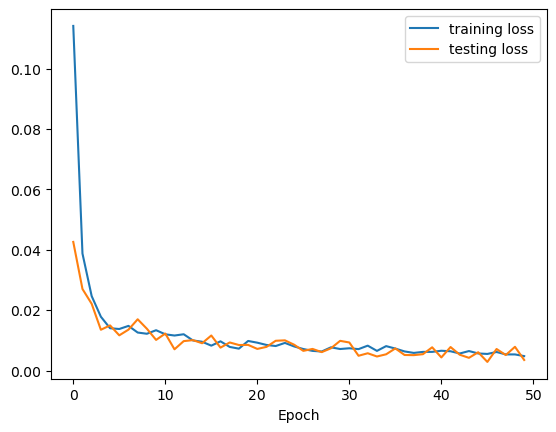

In [6]:
model_dir = os.path.join(base_dir, "results_BSD", model_name, "model.pt")
if os.path.exists(model_dir):
    model.load_state_dict(torch.load(model_dir).state_dict())
else:
    train(model, optimizer, epochs, train_set, test_set, batch_size, model_name, compute_loss=compute_loss)

In [7]:
for noise_level, time in [(10, 5), (25, 12), (50, 20)]:
    test(model, test_set, batch_size, model_name, noise_level, denoise=denoise, base_dir=base_dir, t=time)

noise_level: 10


25it [00:49,  2.00s/it]


PSNR noisy: 31.71 +- 0.16
SSIM noisy: 0.840 +- 0.066
PSNR denoised: 35.36 +- 1.40
SSIM denoised: 0.942 +- 0.015
noise_level: 25


25it [01:48,  4.33s/it]


PSNR noisy: 23.92 +- 0.26
SSIM noisy: 0.557 +- 0.116
PSNR denoised: 30.04 +- 1.08
SSIM denoised: 0.839 +- 0.038
noise_level: 50


25it [02:53,  6.96s/it]


PSNR noisy: 18.31 +- 0.29
SSIM noisy: 0.322 +- 0.103
PSNR denoised: 25.05 +- 0.67
SSIM denoised: 0.642 +- 0.081


**WaveDiffusion on Wavelet Space**

In [5]:
model = WaveDiffusion(image_size=image_size, image_channels=3, time_range=time_range, wavespace=True, device=device).to(device)
model_name = "WaveDiffusionOnWave"
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [6]:
model_dir = os.path.join(base_dir, "results_BSD", model_name, "model.pt")
if os.path.exists(model_dir):
    model.load_state_dict(torch.load(model_dir).state_dict())
else:
    train(model, optimizer, epochs, train_set, test_set, batch_size, model_name, compute_loss=compute_loss)

 96%|█████████▌| 48/50 [19:55<00:49, 24.75s/it, Step=4809/5000, training loss=0.050]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [7]:
for noise_level, time in [(10, 5), (25, 12), (50, 20)]:
    test(model, test_set, batch_size, model_name, noise_level, denoise=denoise, base_dir=base_dir, t=time)

noise_level: 10


25it [00:17,  1.42it/s]


PSNR noisy: 31.71 +- 0.16
SSIM noisy: 0.840 +- 0.066
PSNR denoised: 33.28 +- 1.02
SSIM denoised: 0.901 +- 0.027
noise_level: 25


25it [00:30,  1.22s/it]


PSNR noisy: 23.92 +- 0.26
SSIM noisy: 0.557 +- 0.117
PSNR denoised: 28.60 +- 1.14
SSIM denoised: 0.772 +- 0.048
noise_level: 50


25it [00:42,  1.72s/it]


PSNR noisy: 18.31 +- 0.29
SSIM noisy: 0.322 +- 0.103
PSNR denoised: 24.54 +- 0.80
SSIM denoised: 0.595 +- 0.075
